IMPORTING LIBRARIES

In [2]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
#from keras.layers import Dense, BatchNormalization, Dropout, LSIM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
#from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)


LOADING DATA

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

N/B:
- Dataset contains null values
- Dataset includes numeric and categorical values

DATA VISUALIZATION AND CLEANING.
Steps involved:
- Count plot of target column
- Correlation amongst numeric attributes
- Parse Dates into datetime
- Encoding days and months as continuous cyclic features

<Axes: xlabel='RainTomorrow', ylabel='count'>

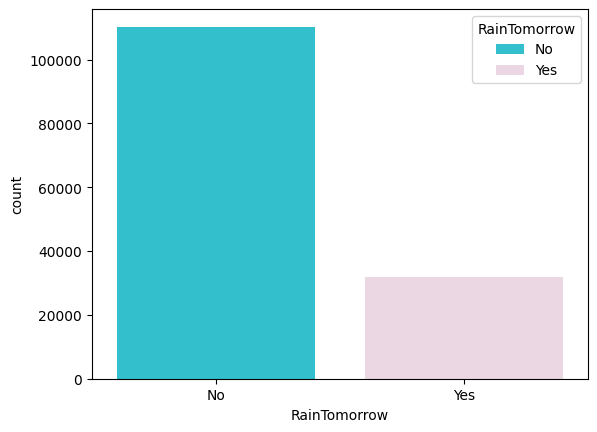

In [5]:
#Evaluate the target column and find out if data is imbalanced or not
cols = ["#19d4e6", "#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols, hue= data["RainTomorrow"])

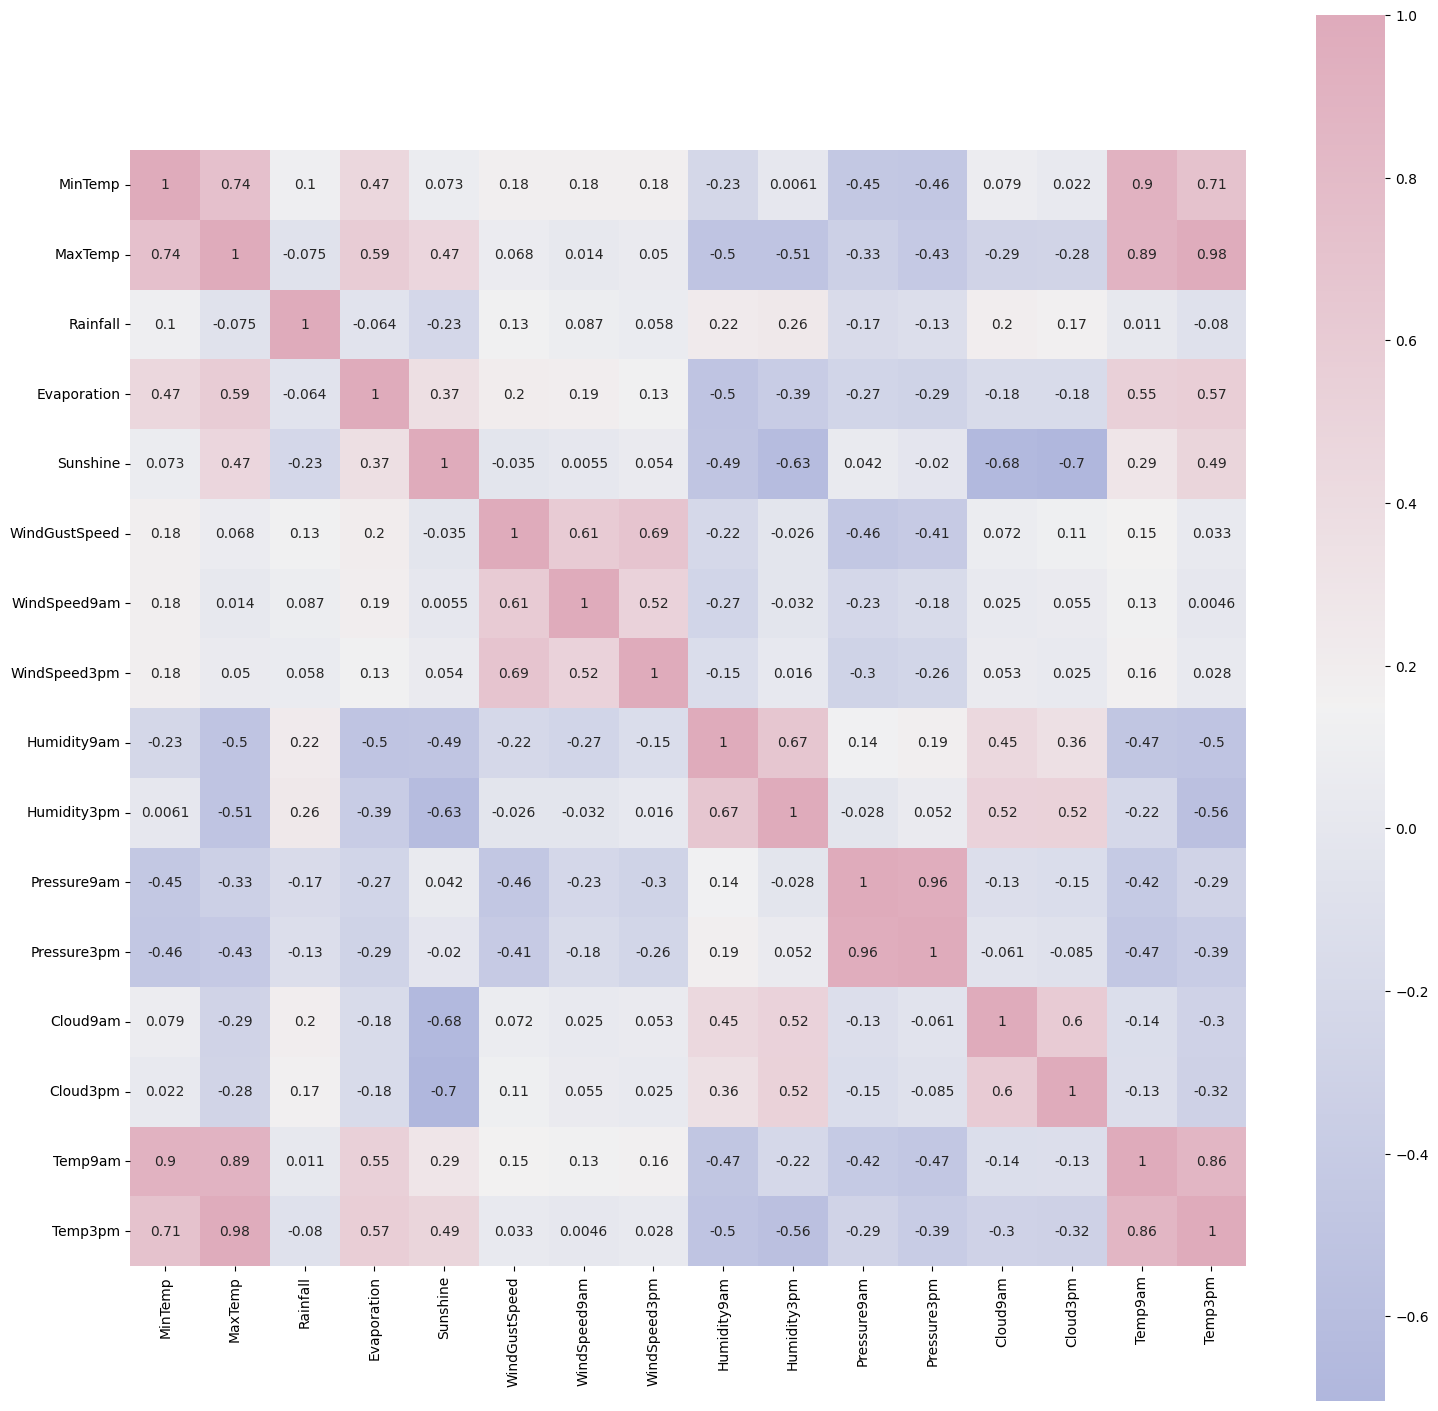

In [6]:
#Correlation amongst numeric attributes
corrmat = data.corr(numeric_only=True)
cmap = sns.diverging_palette(260, -10, s = 50, l = 75, n = 6, as_cmap= True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat, cmap= cmap, annot=True, square=True)
plt.show()

Parsing Dates into datetime(months and dates in a cyclic continuous feature). Date and time are inherently cyclical. To let the Artificial Neural Network know that a feature is cyclical, we split it into periodic subsections(Years, months and days) For each subsection, we create two new features, deriving a sine transform and a cosine transform of the subsection feature.

In [7]:
#Parsing datetime
#Exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

,count
Date,
10,145460


In [8]:
data["Date"] = pd.to_datetime(data["Date"])
#Create Year column
data["Year"] = data.Date.dt.year

#Function to encode datetime into cyclic parameters.

def encode(data, col, max_val):
  data[col + "_sin"] = np.sin(2 * np.pi * data[col]/max_val)
  data[col + "_cos"] = np.cos(2 * np.pi * data[col]/max_val)
  return data

data["month"] = data.Date.dt.month
data = encode(data, "month", 12)
data["day"] = data.Date.dt.day
data = encode(data, "day", 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,Year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964
